In [1]:
import os
import json
import datetime

import pandas as pd
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


%matplotlib inline

In [2]:
# extract city_day.csv, overwrite if necessary, NO Questions!
!unzip -xud ../ ../dataset.zip city_day.csv

Archive:  ../dataset.zip


In [3]:
# convert py datetime to string
def format_date(date):
    return date.strftime('%d-%m-%Y')


# get generator obj, to generate List of (start dates, end dates) of lockdown phases
def get_lockdown_phases():
    starting_dates = (
        datetime.datetime(2020, 3, 25),
        datetime.datetime(2020, 4, 15),
        datetime.datetime(2020, 5, 4),
        datetime.datetime(2020, 5, 18),
        datetime.datetime(2020, 6, 1)
    )
    no_of_dates = len(starting_dates)
    for idx in range(no_of_dates-1):
        yield starting_dates[idx], starting_dates[idx+1]


# get tuple of cities, to which analysis has to be done
def get_cities():
    return (
        'Lucknow', 'Amritsar', 'Gurugram',
        'Ahmedabad', 'Brajrajnagar', 'Talcher', 'Jaipur',
        'Guwahati', 'Delhi', 'Kolkata',
        'Amaravati', 'Visakhapatnam', 'Mumbai', 'Chennai', 'Hyderabad',
        'Patna', 'Jorapokhar', 'Bengaluru', 'Coimbatore', 'Thiruvananthapuram'
    )


# get dataframes of cities in the format "List:lockdown_phases[Dict:cities[str:city_name, pd.DataFrame]]"
def get_dataframes(cities, lockdown_phases, path_prefix='.'):
    dfs = [dict() for x in range(len(lockdown_phases))]
    first_date, last_date = lockdown_phases[0][0], lockdown_phases[-1][1]
    
    city_day = pd.read_csv(
                        os.path.join(path_prefix, 'city_day.csv'),
                        dtype={'City': 'category', 'AQI': 'float'}, parse_dates=['Date']
                    )
    city_day = city_day[(city_day['Date'] >= first_date) & (city_day['Date'] < last_date)]
    
    for idx,(from_date,to_date) in enumerate(lockdown_phases):
        tcity_day = city_day[(city_day['Date'] >= from_date) & (city_day['Date'] < to_date)]
        for city in cities:
            dfs[idx][city] = tcity_day[tcity_day['City'] == city].reset_index(drop=True)[['Date', 'AQI']].interpolate(limit_direction='both')
    return dfs


# get max AQI value from all the cities among all the lockdown phases
def get_max_AQI(dfs):
    return max(max(df['AQI'].max() for df in dfs_city.values()) for dfs_city in dfs)


# get max number of days within lockdown phases
def get_max_lockdown_day_delta(lockdown_phases):
    return max(e-s for s,e in lockdown_phases)


# get color for given AQI value(for the graphs)
def get_AQI_bucket_color(x):
    if x <= 50:      return "green"
    elif x <= 100:   return "limegreen"
    elif x <= 200:   return "gold"
    elif x <= 300:   return "darkorange"
    elif x <= 400:   return "red"
    elif x > 400:    return "darkred"
    else:            return np.NaN


# get remark/bucket name for given AQI value
def get_AQI_bucket(x):
    if x <= 50:      return "Good"
    elif x <= 100:   return "Satisfactory"
    elif x <= 200:   return "Moderate"
    elif x <= 300:   return "Poor"
    elif x <= 400:   return "Very Poor"
    elif x > 400:    return "Severe"
    else:            return np.NaN

In [4]:
lockdown_phases = tuple(get_lockdown_phases())
cities = get_cities()
dfs = get_dataframes(cities, lockdown_phases, '../')

max_AQI = get_max_AQI(dfs)
max_lockdown_day_delta = get_max_lockdown_day_delta(lockdown_phases)
oneday_delta = datetime.timedelta(days=1)

In [5]:
print('lockdown phases:')
for idx,(from_date,to_date) in enumerate(lockdown_phases, start=1):
    print('\tphase {}: [{}, {})'.format(idx, format_date(from_date), format_date(to_date)))
print('\ncities: {}'.format(', '.join(cities)))

print('\nmax AQI: {}, max lockdown days: {}'.format(max_AQI, max_lockdown_day_delta.days))

lockdown phases:
	phase 1: [25-03-2020, 15-04-2020)
	phase 2: [15-04-2020, 04-05-2020)
	phase 3: [04-05-2020, 18-05-2020)
	phase 4: [18-05-2020, 01-06-2020)

cities: Lucknow, Amritsar, Gurugram, Ahmedabad, Brajrajnagar, Talcher, Jaipur, Guwahati, Delhi, Kolkata, Amaravati, Visakhapatnam, Mumbai, Chennai, Hyderabad, Patna, Jorapokhar, Bengaluru, Coimbatore, Thiruvananthapuram

max AQI: 315.0, max lockdown days: 21


In [6]:
# get List of 'matplotlib line obj' and List of 'AQI bucket name' between 0 and max_AQI, for adding legend in graph
def get_AQI_legend(max_AQI):
    AQI_margin_values = (50, 100, 200, 300, 400, 500)
    AQI_legend_lines, AQI_legend_texts = [], []
    
    flag = False
    for val in AQI_margin_values:
        if flag: break
        if val > max_AQI: flag = True
        AQI_legend_lines.append(mlines.Line2D([0], [0], color=get_AQI_bucket_color(val), lw=4))
        AQI_legend_texts.append(get_AQI_bucket(val))
    return AQI_legend_lines, AQI_legend_texts


# just drop all na, and return list of Date and AQI
def get_plot_data(df):
    x, y = [], []
    for idx,row in df.dropna().iterrows():
        x.append(row['Date'])
        y.append(row['AQI'])
    return x, y


# given dataframe of type "Dict[str, pd.DataFrame]" plot line graph
def plot_all_dfs_line(title, dfs, marker='--o', tick_spacing=1, figsize=None, bbox_to_anchor=None, save_file_prefix=None):
    fig = plt.figure(figsize=figsize)
    axes = plt.gca()
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    axes.xaxis.set_major_locator(mticker.MultipleLocator(tick_spacing))
    axes.set_ylim([0, max_AQI+10])

    def __plot(df, m, l):
        x, y = get_plot_data(df)
        plt.plot(x, y, m, label=l)
    
    # if marker is list/tuple, use each element to plot each dataframes in "Dict", else use same marker for all dataframes
    if isinstance(marker, (list, tuple)):
        assert len(marker) == len(dfs)
        for m,(key,df) in zip(marker, dfs.items()):
            __plot(df, m, key)
    else:
        for key,df in dfs.items():
            __plot(df, marker, key)
        
    plt.gcf().autofmt_xdate()
    plt.legend(loc='upper right', bbox_to_anchor=bbox_to_anchor)
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.title(title)

    # if save_file_prefix is available, save under that directory, else show graphs inline
    if save_file_prefix:
        plt.savefig(os.path.join(save_file_prefix, f'{title}.png'), bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()


# given dataframes of type "List:lockdown_phases[Dict:cities[str:city_name, pd.DataFrame]]", call plot_all_dfs_line foreach lockdown phase
def plot_lockdown_wise_line(dfs, save_file_prefix=None):
    marker = ['-o']*10 + ['--s']*10
    for idx,tdfs in enumerate(dfs, start=1):
        plot_all_dfs_line('Phase {}'.format(idx), tdfs, marker, figsize=(20, 10), bbox_to_anchor=(1.15, 1), save_file_prefix=save_file_prefix)


# given dataframes of type "List:lockdown_phases[Dict:cities[str:city_name, pd.DataFrame]]", call plot_all_dfs_line foreach city
def plot_city_wise_line(dfs, save_file_prefix=None):
    for city in cities:
        tdfs = dict()
        for idx,tdf in enumerate(dfs):
            tdfs['Phase {}'.format(idx+1)] = tdf[city]
        plot_all_dfs_line(city, tdfs, tick_spacing=5, figsize=(20, 10), bbox_to_anchor=(1.1, 1), save_file_prefix=save_file_prefix)

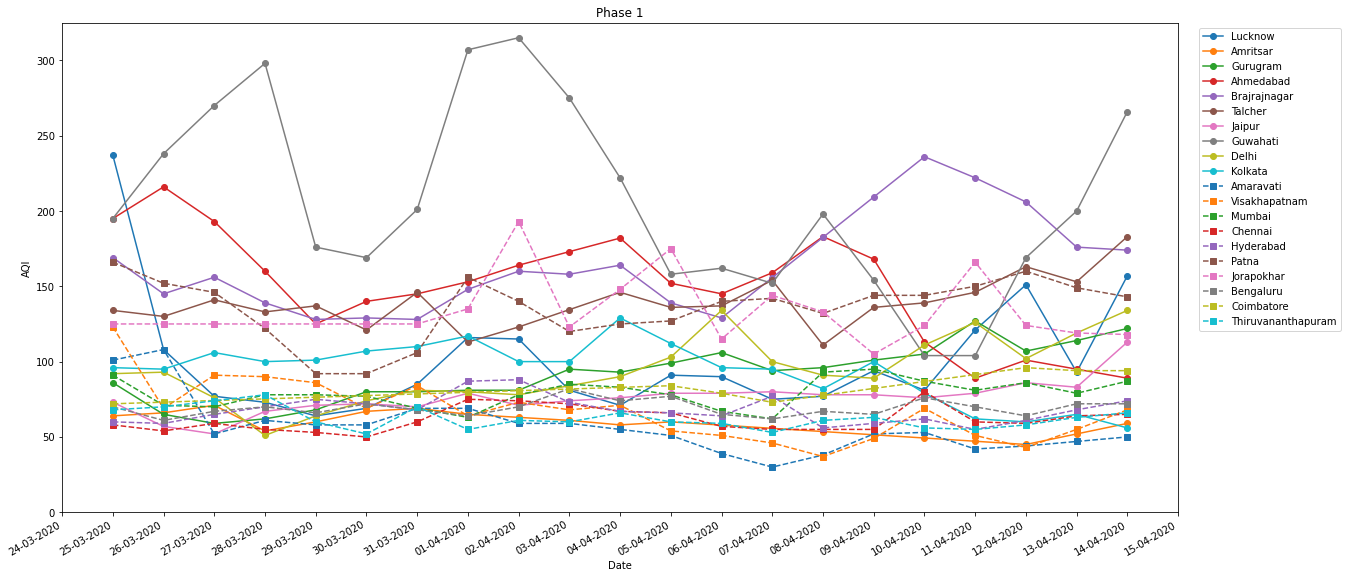

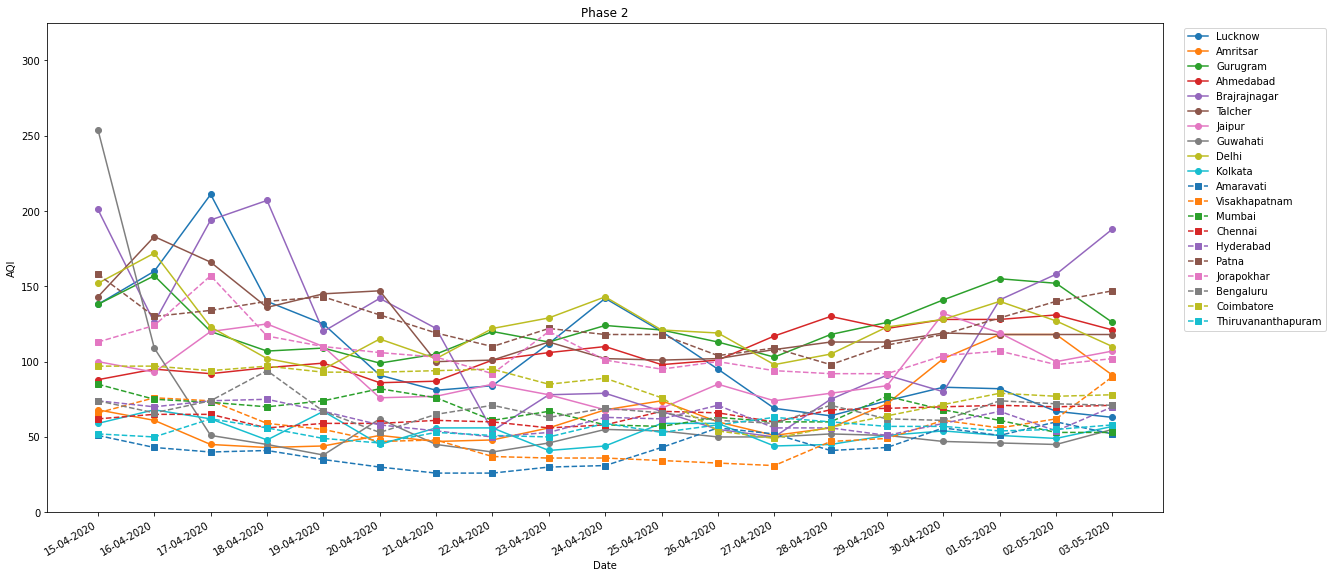

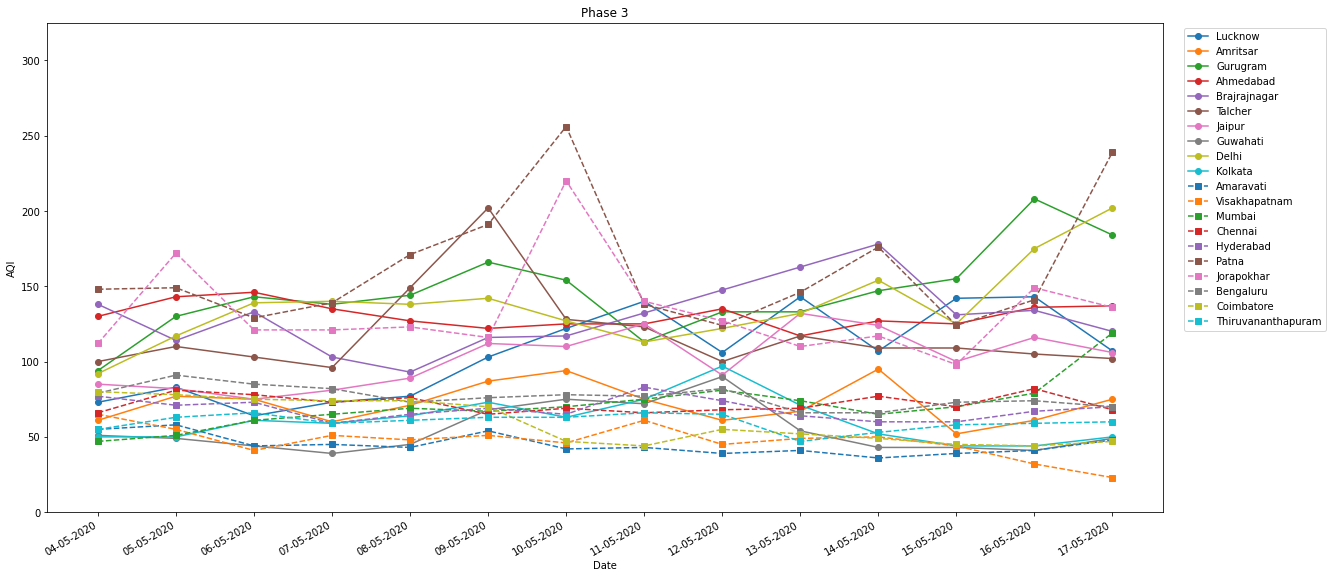

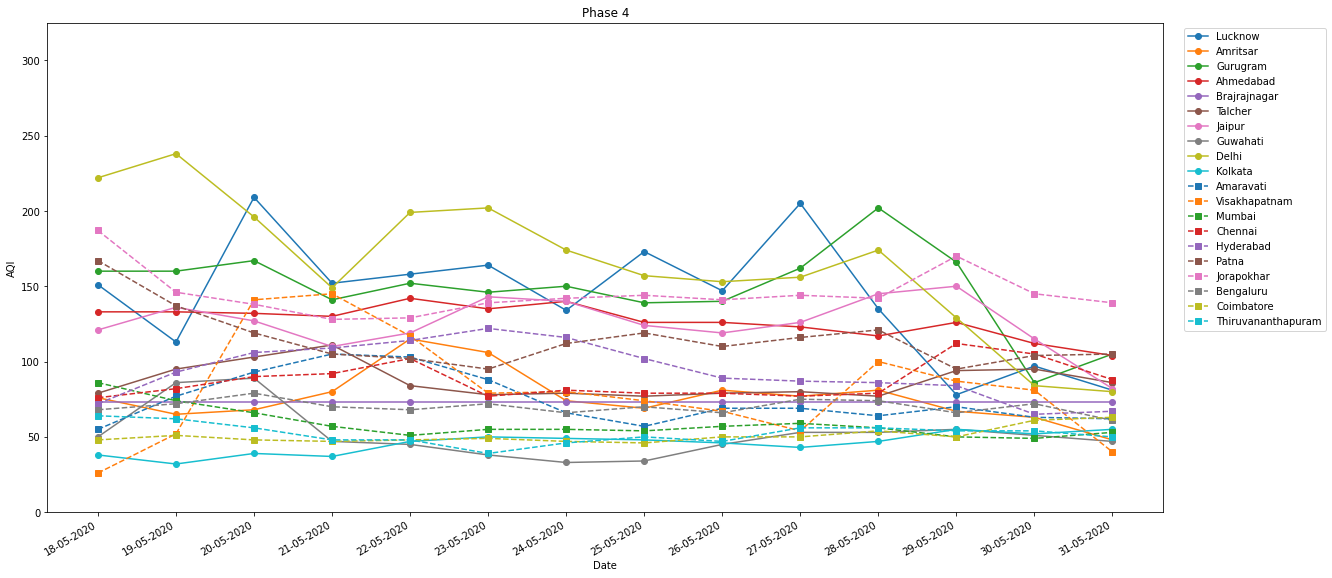

In [7]:
#plot_lockdown_wise_line(dfs, '../aim2/lockdown_phases/phase_wise')      # save under the directory given as 2nd parameter
plot_lockdown_wise_line(dfs)                                            # plot inline in jupyter

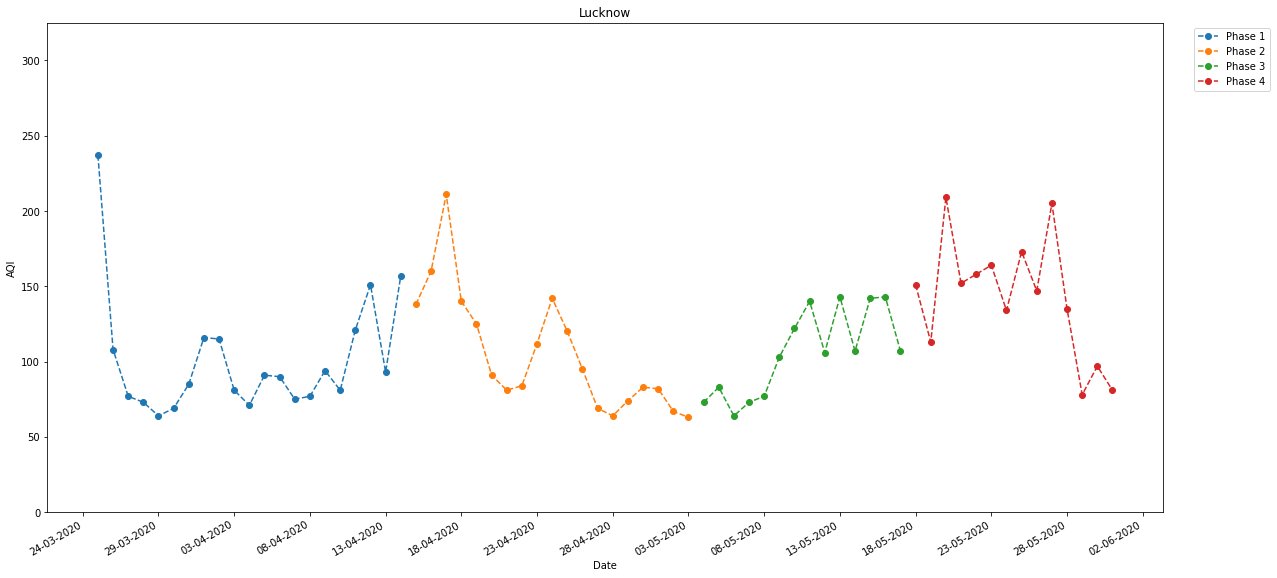

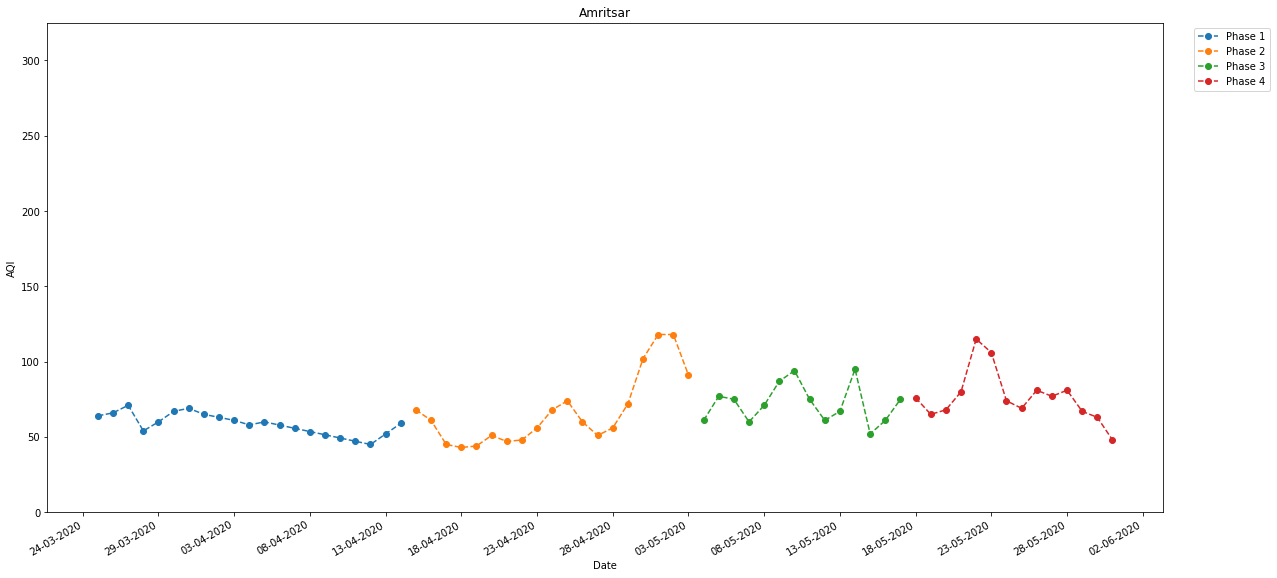

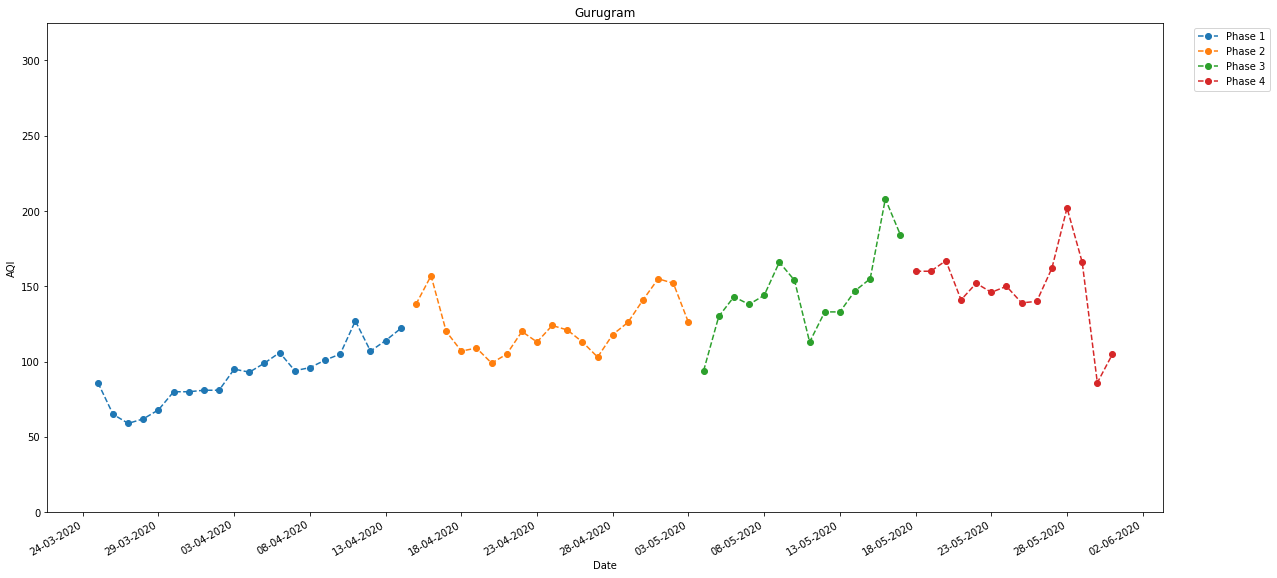

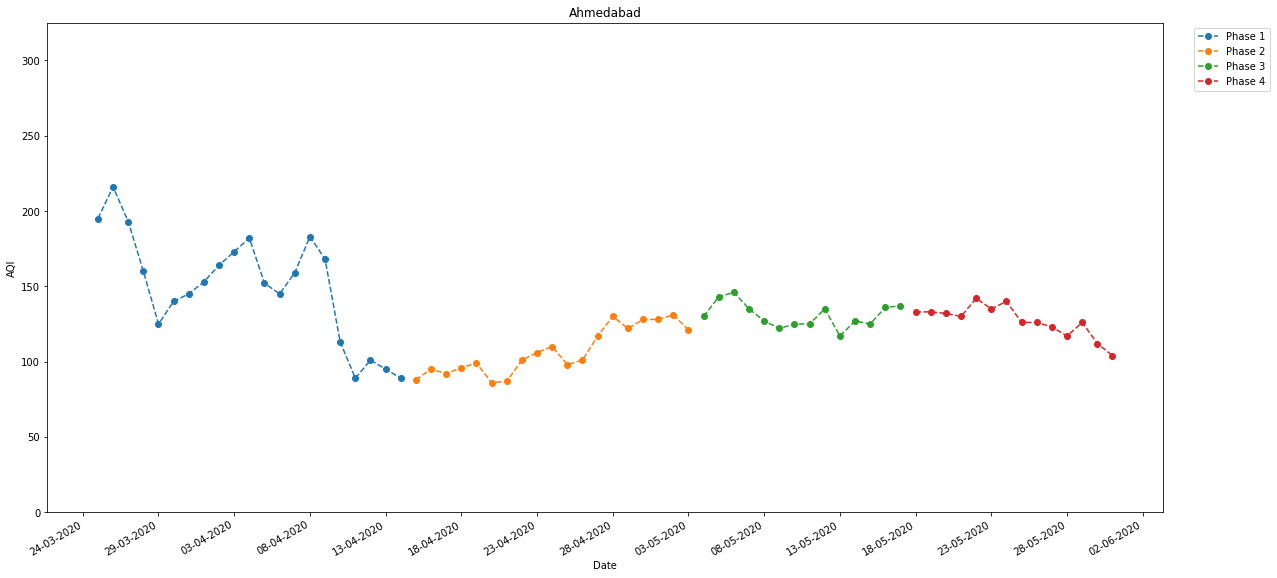

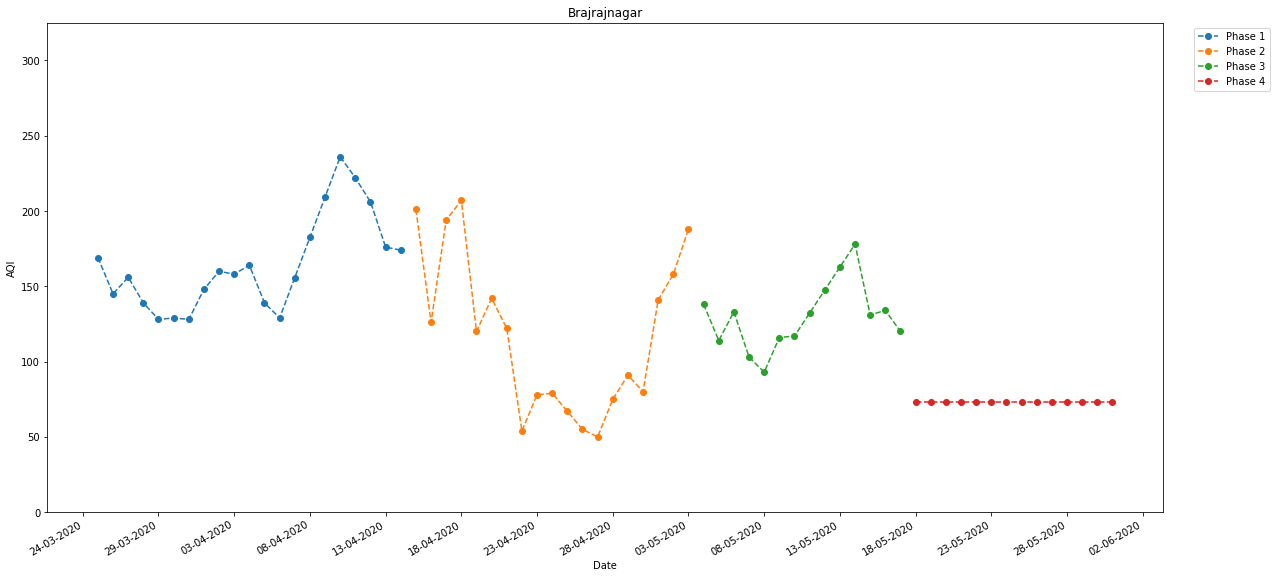

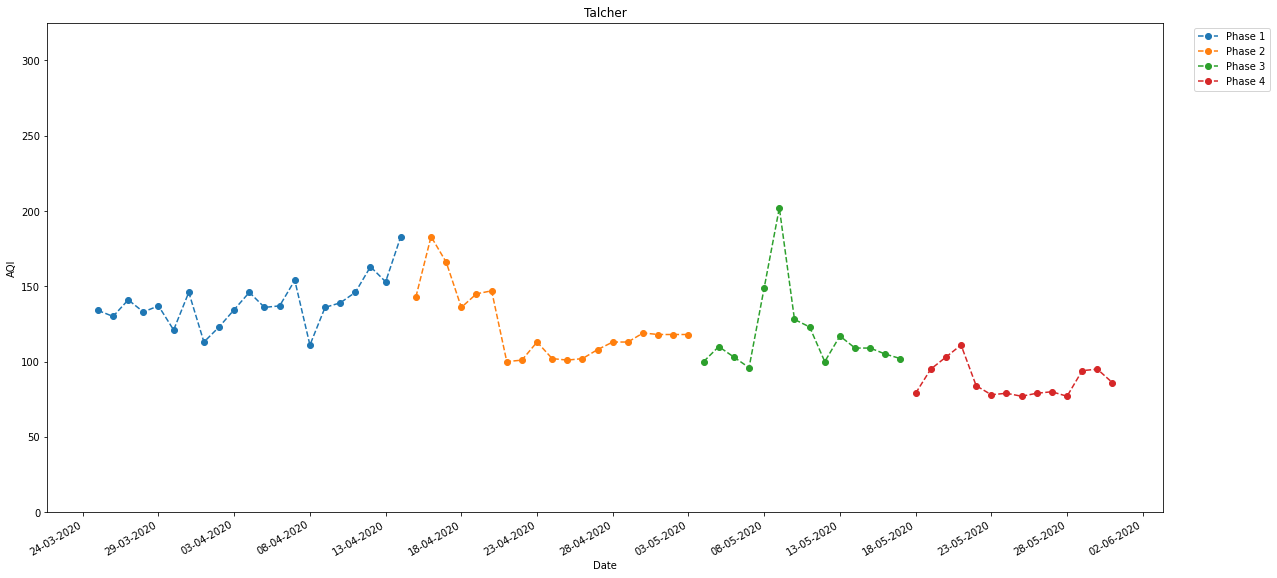

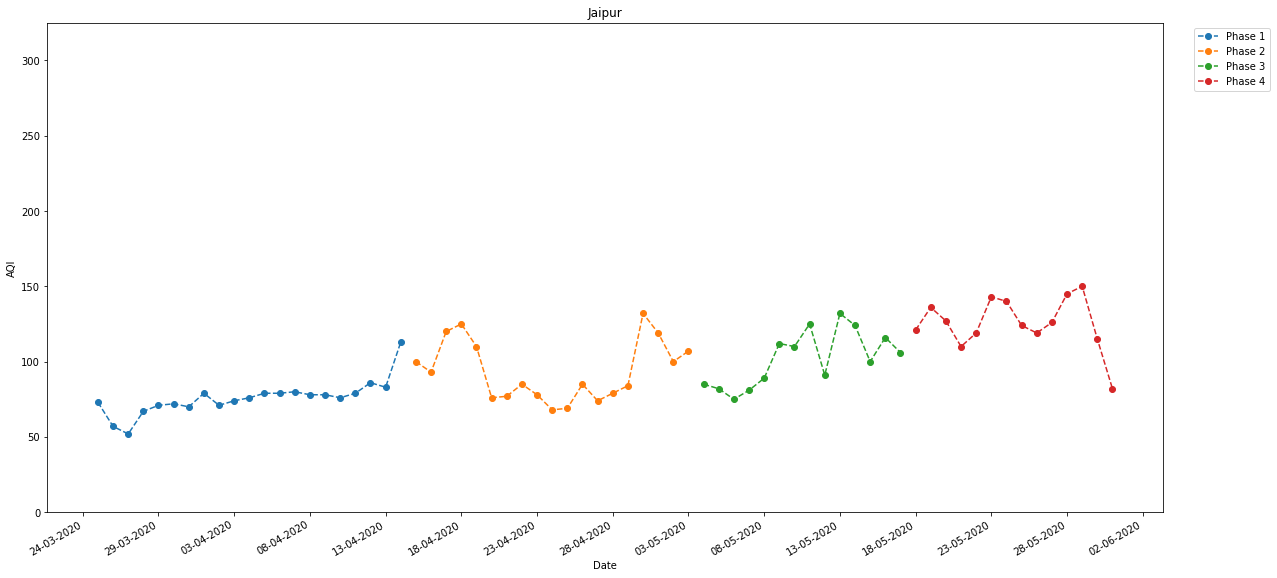

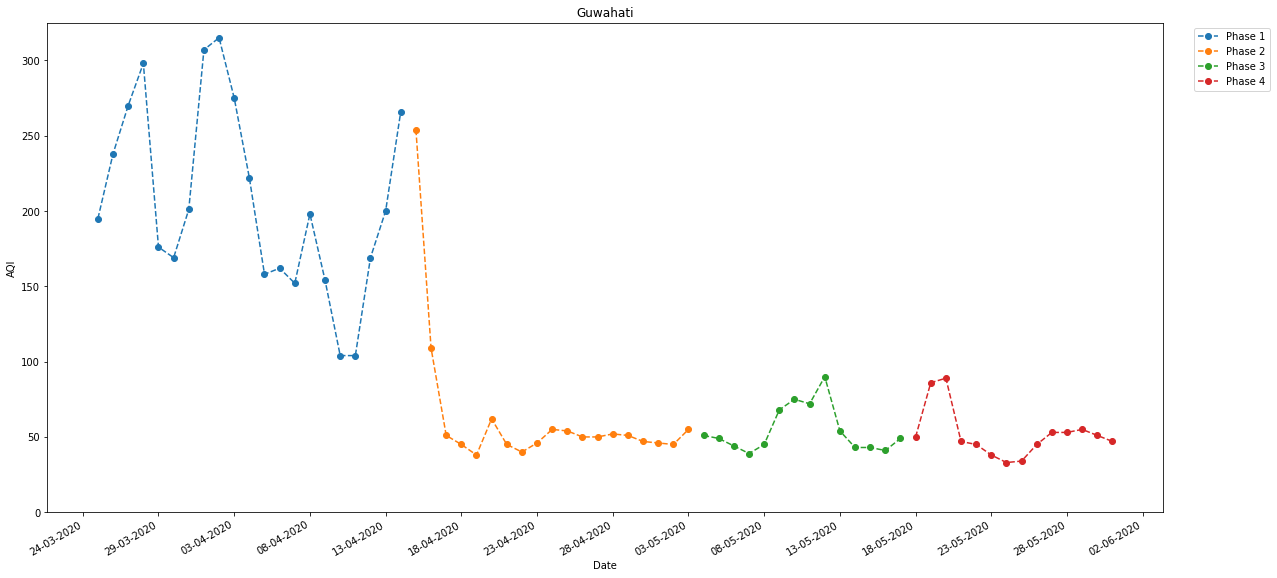

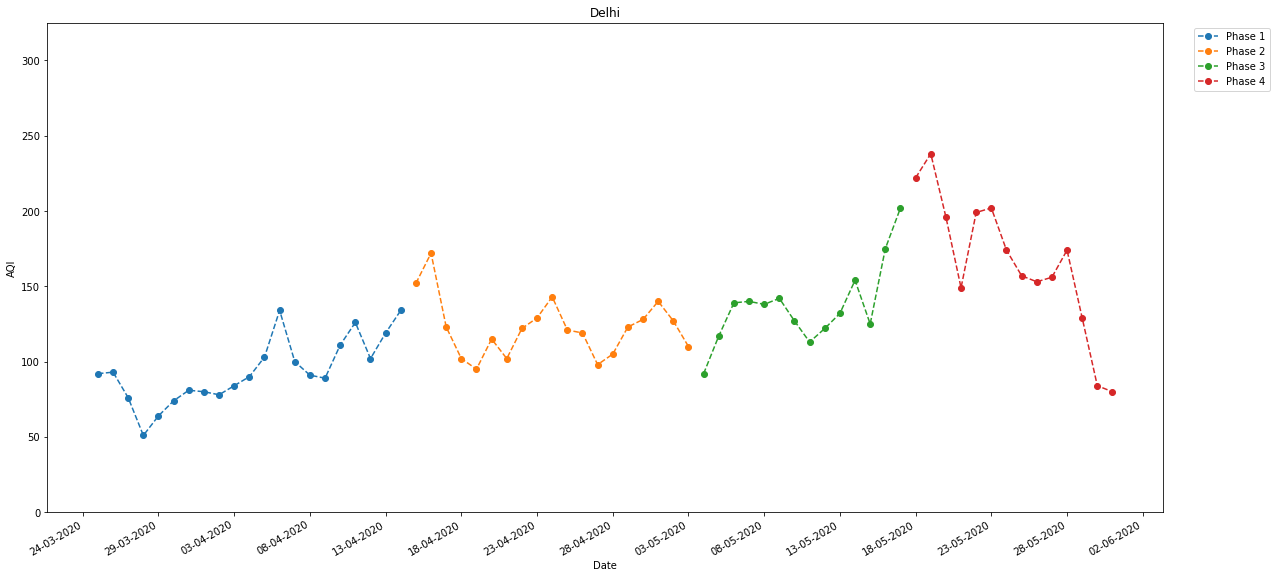

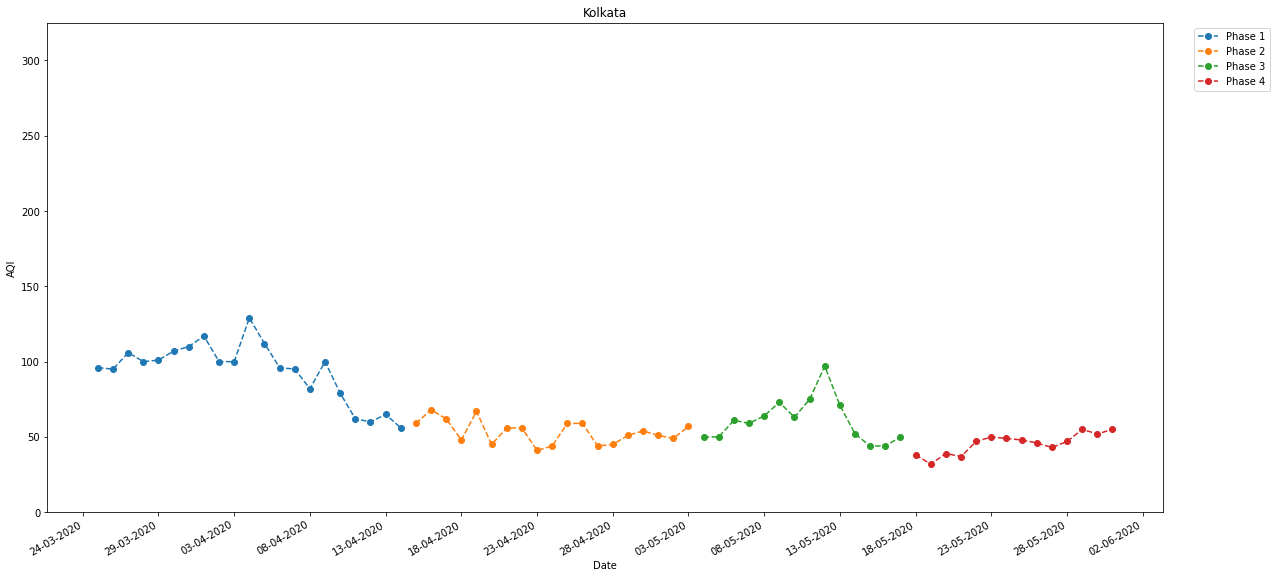

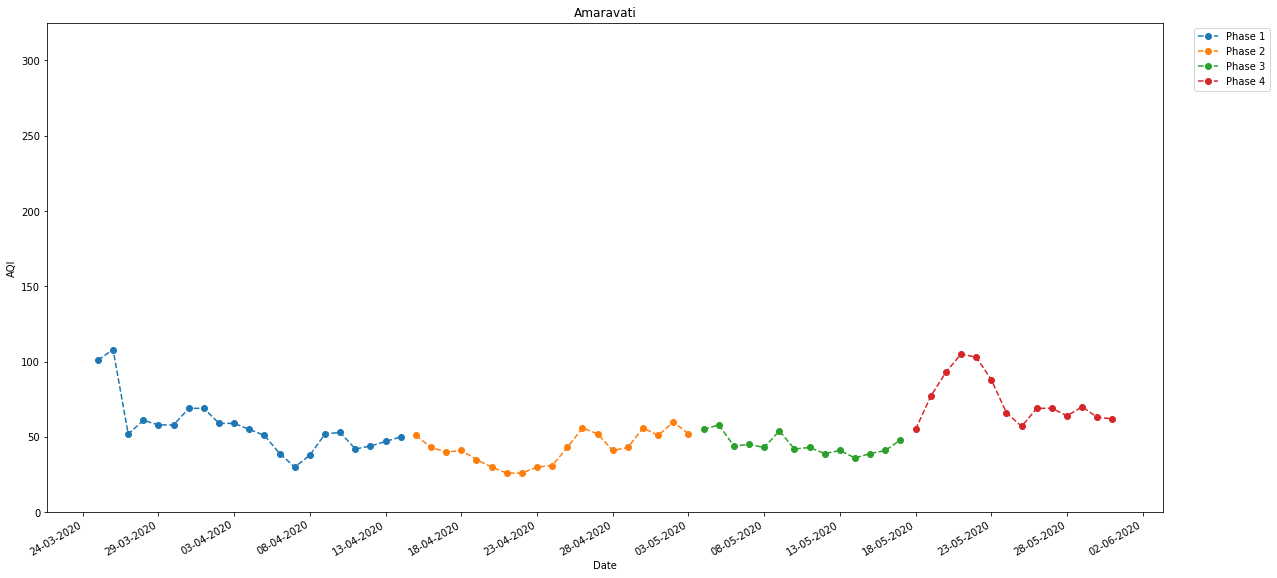

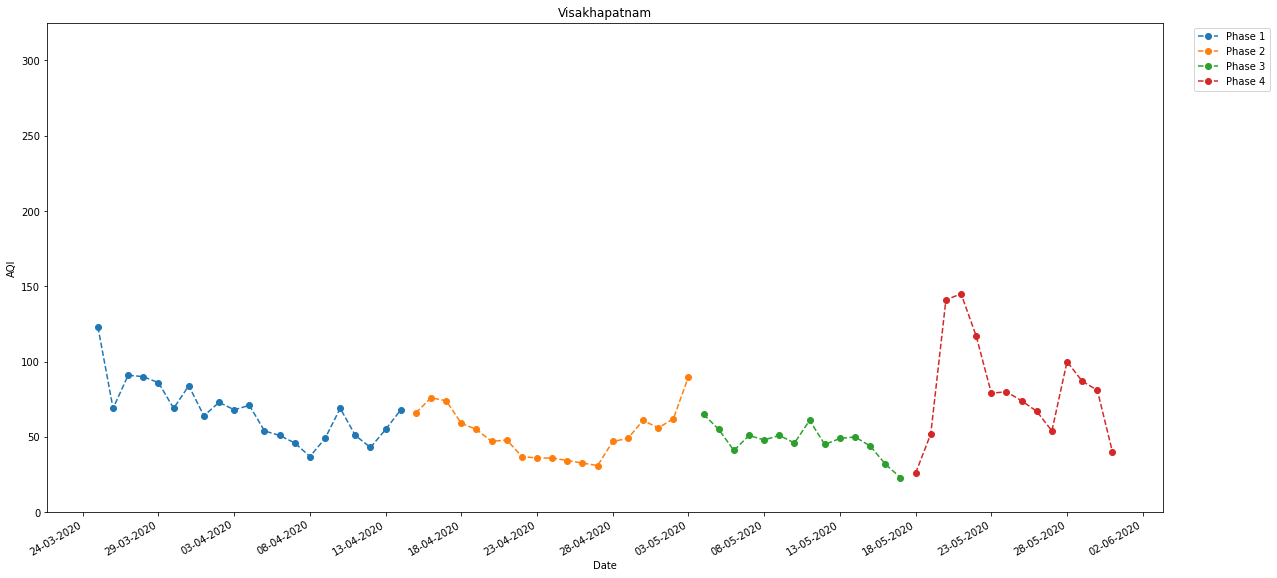

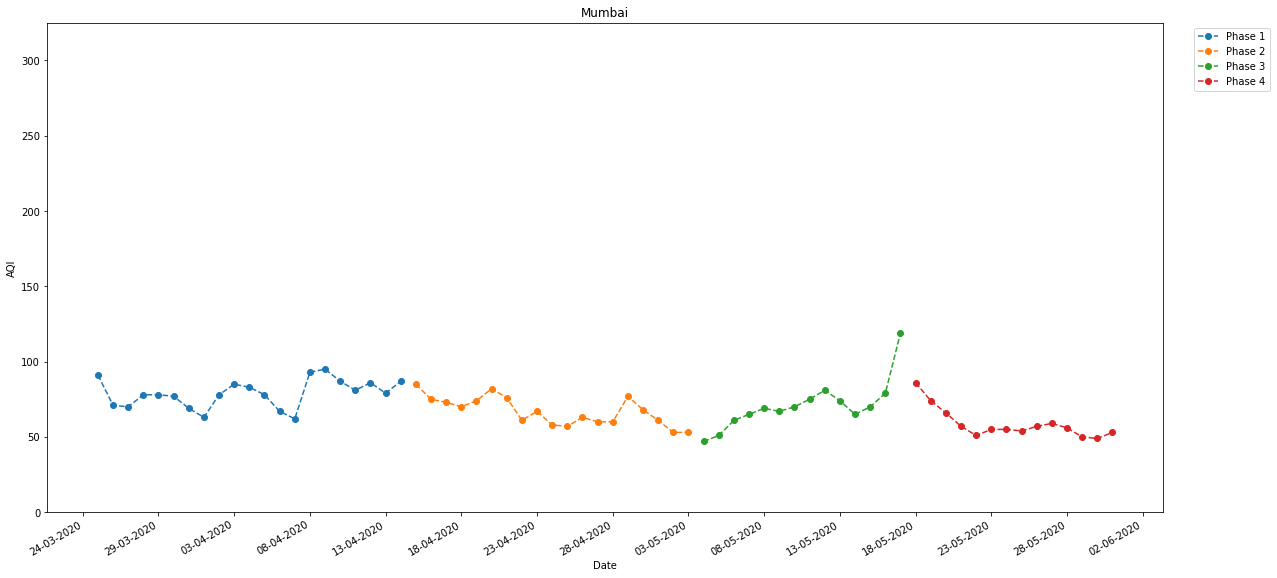

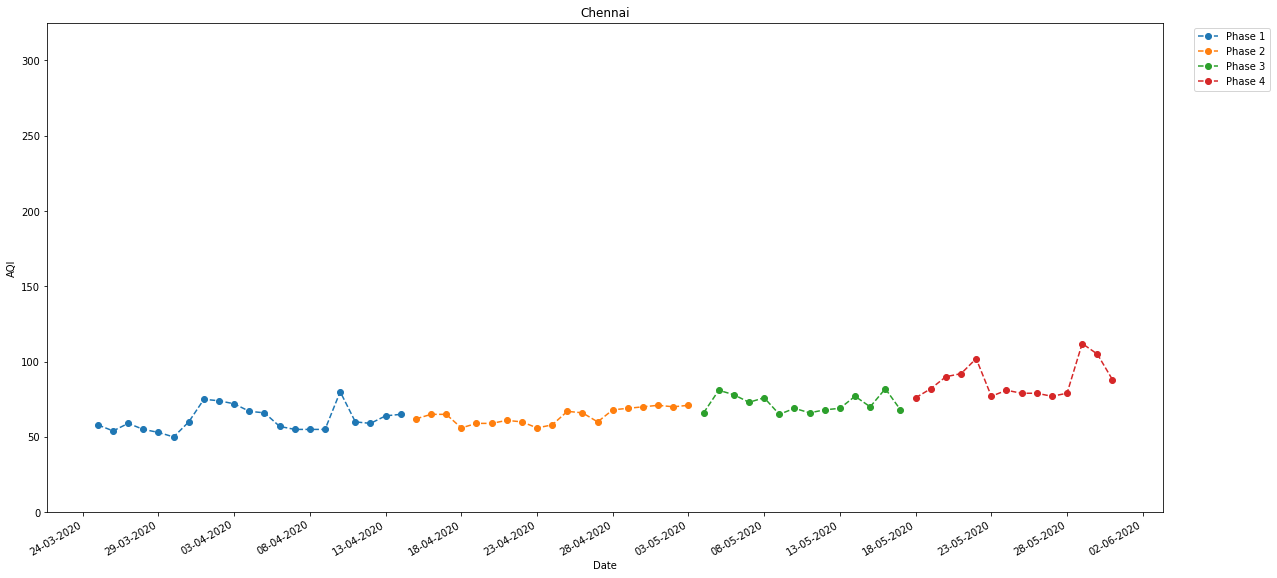

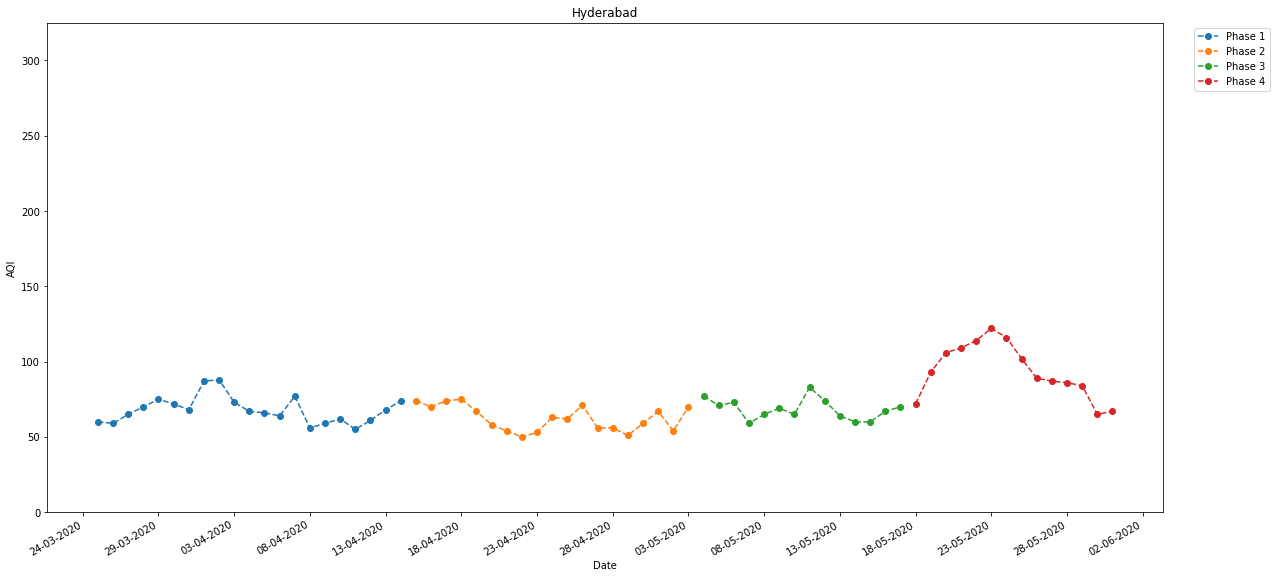

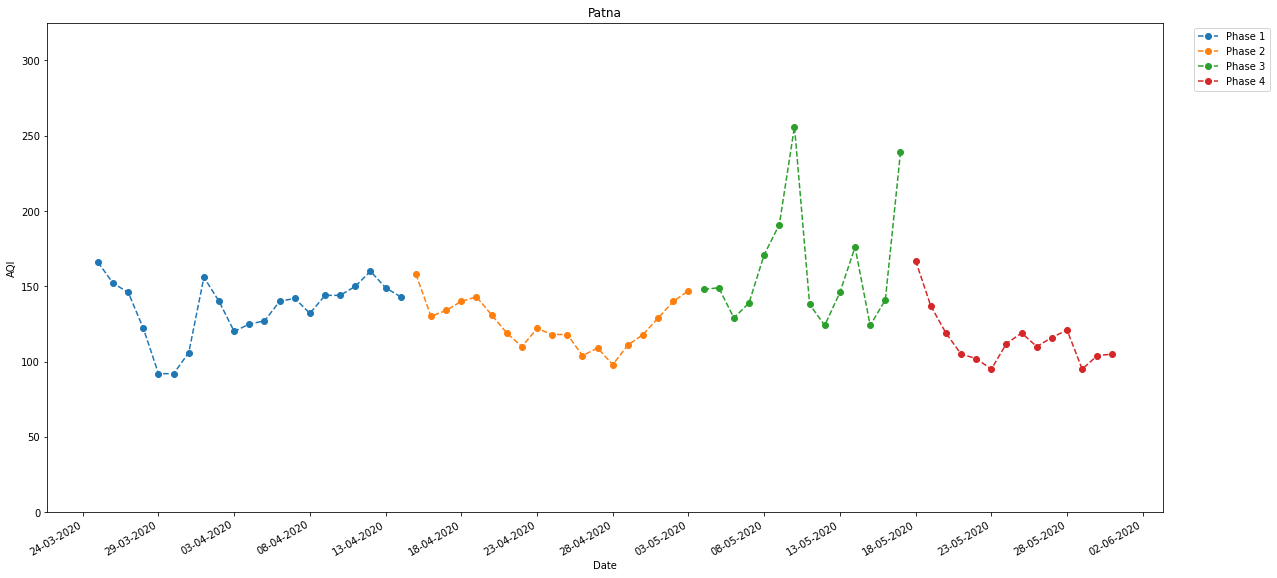

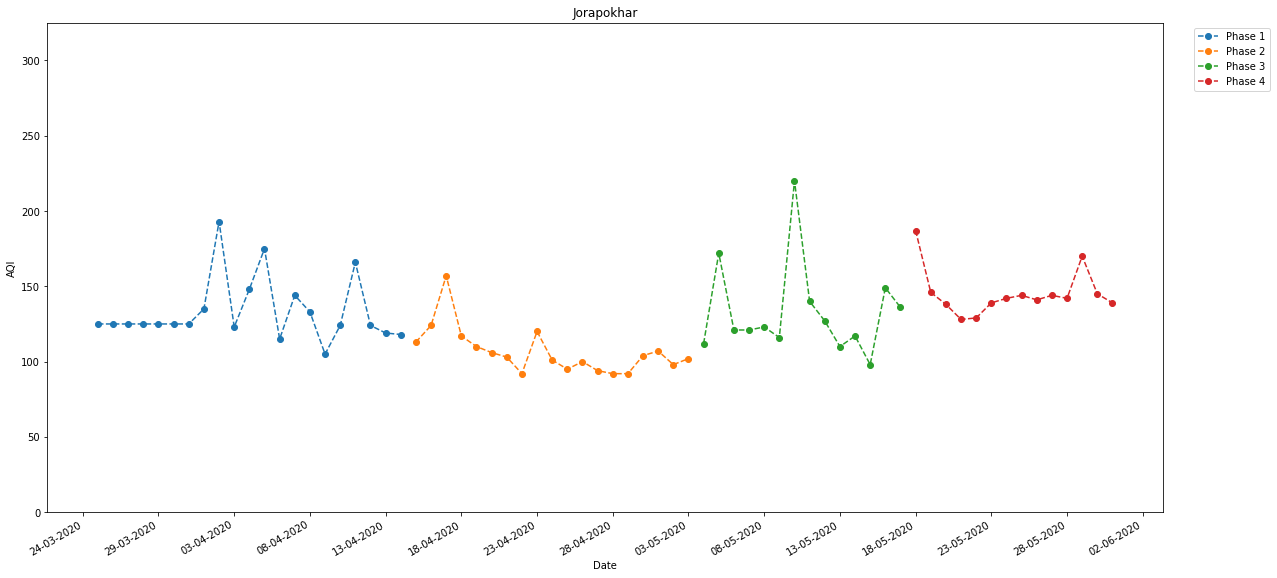

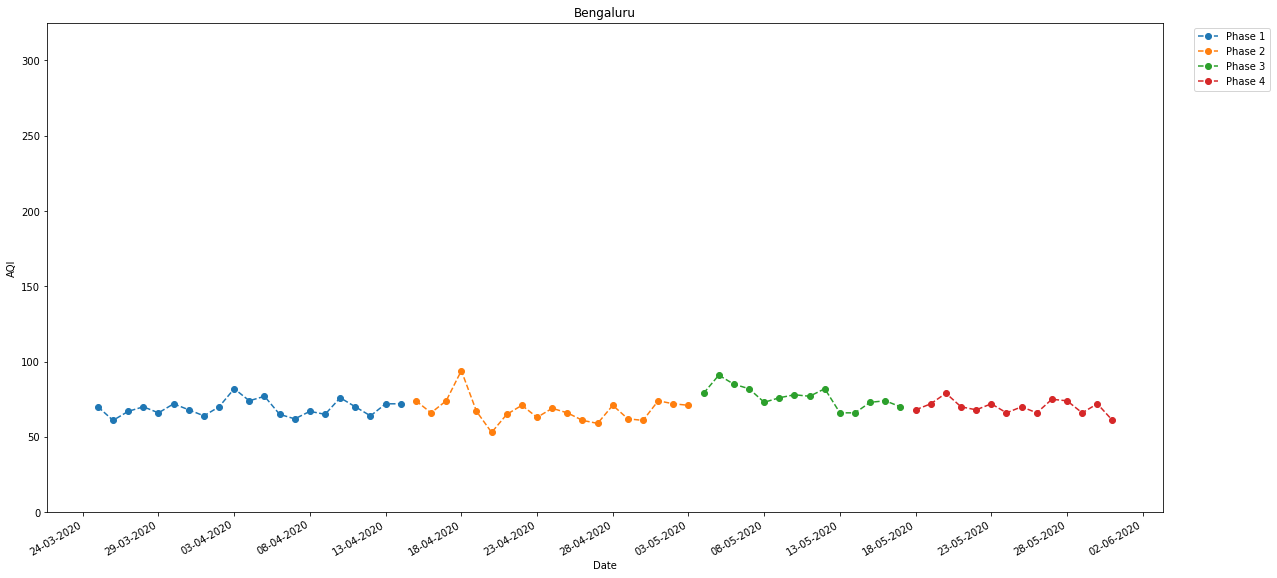

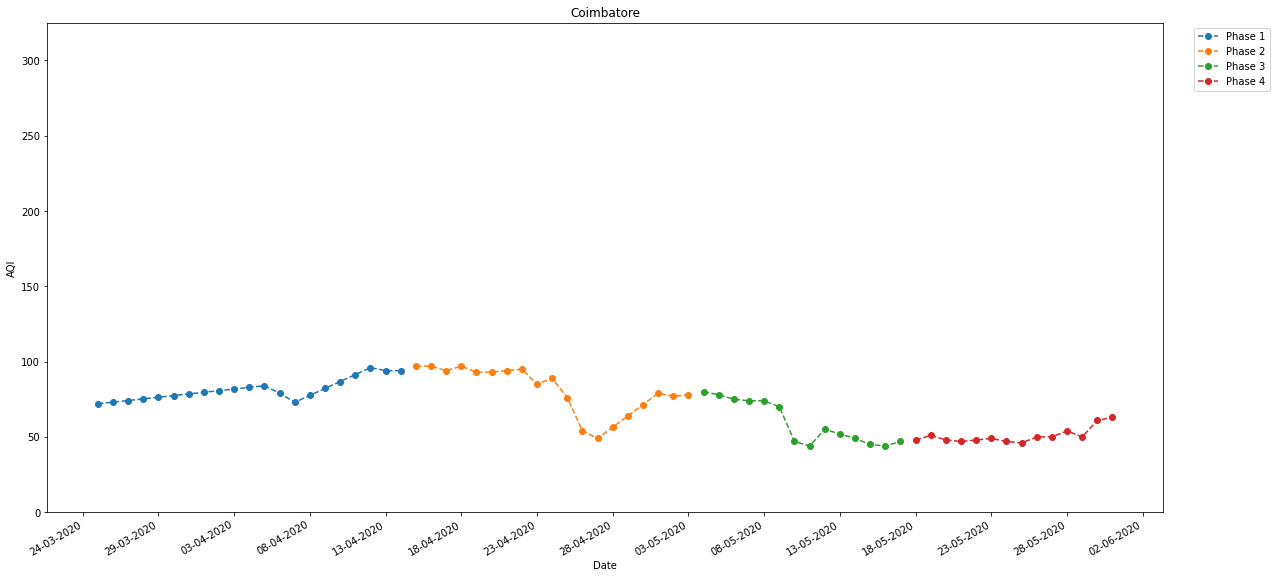

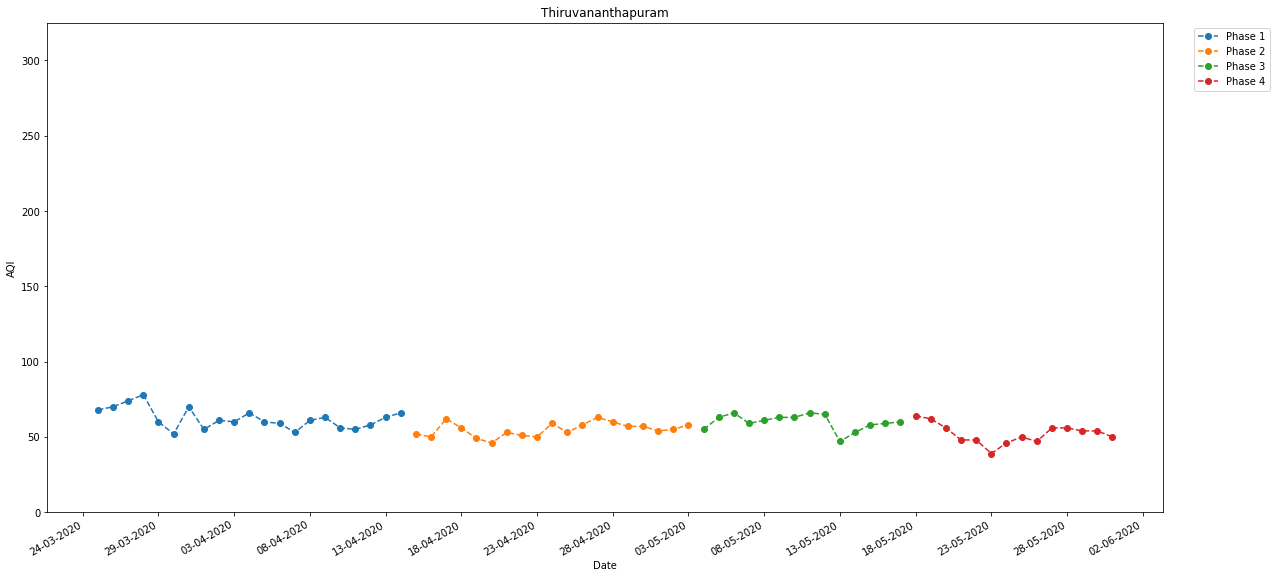

In [8]:
#plot_city_wise_line(dfs, '../aim2/lockdown_phases/city_wise')      # save under the directory given as 2nd parameter
plot_city_wise_line(dfs)                                           # plot inline in jupyter